# 08 — Dataset Splitting and Leakage

Purpose: learn train/val/test splitting, see concrete leakage examples, and run a simple manual k-fold loop—without external libraries.

## Learning goals
- Create reproducible train/val/test splits.
- Demonstrate two leakage patterns:
  1) fitting preprocessing on all data (including test)
  2) target leakage via a feature derived from the label
- Implement a small k-fold evaluation loop manually.
- Use plots to make leakage effects obvious.

## Prerequisites
- Notebook 07 (train/val mindset).
- Basic NumPy slicing and indexing.
- Comfort with simple training loops.

## Key ideas
- Test data is a one-time audit. Do not use it to make decisions.
- Leakage inflates metrics and fails in production.
- Preprocessing must be fit on train only.
- If a feature encodes the label (directly or indirectly), you are not learning.

## Minimal theory
- Split: train (fit parameters), val (choose hyperparameters), test (final estimate).
- k-fold: rotate validation fold to reduce variance of estimates.
- Leakage is any information used during training/selection that would not be available at inference.

train/val/test: (540, 2) (180, 2) (180, 2)


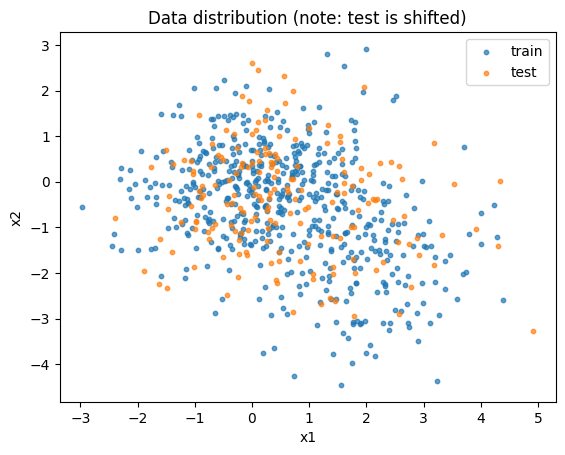

In [1]:
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
rng = np.random.default_rng(SEED)

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def bce_from_logits(z, y):
    t = np.maximum(z, 0) - z*y + np.log1p(np.exp(-np.abs(z)))
    return float(np.mean(t))

def standardize_fit(x):
    mu = x.mean(axis=0, keepdims=True)
    sigma = x.std(axis=0, keepdims=True) + 1e-12
    return mu, sigma

def standardize_apply(x, mu, sigma):
    return (x - mu) / sigma

def split_three(x, y, ratios=(0.6,0.2,0.2), rng=None):
    rng = np.random.default_rng(0) if rng is None else rng
    N = x.shape[0]
    idx = rng.permutation(N)
    n_tr = int(N*ratios[0])
    n_va = int(N*ratios[1])
    tr = idx[:n_tr]
    va = idx[n_tr:n_tr+n_va]
    te = idx[n_tr+n_va:]
    return x[tr], y[tr], x[va], y[va], x[te], y[te]

def train_logreg(x_tr, y_tr, lr=0.8, steps=600):
    N, D = x_tr.shape
    W = rng.normal(0, 0.1, size=(D,1))
    b = np.zeros((1,1))
    for _ in range(steps):
        z = x_tr @ W + b
        a = sigmoid(z)
        dz = (a - y_tr)/N
        dW = x_tr.T @ dz
        db = np.sum(dz, axis=0, keepdims=True)
        W -= lr*dW
        b -= lr*db
    return W, b

def accuracy_from_logits(z, y):
    p = sigmoid(z)
    yhat = (p >= 0.5).astype(float)
    return float((yhat == y).mean())

def make_shifted_domains(N=900, rng=None):
    rng = np.random.default_rng(0) if rng is None else rng
    # "train" domain centered near (0,0), "test" domain shifted (distribution shift)
    x = rng.normal(0, 1.0, size=(N,2))
    # create label from a linear rule + noise
    W_true = np.array([[1.0], [-1.2]])
    b_true = np.array([[0.2]])
    logits = x @ W_true + b_true + 0.7*rng.normal(size=(N,1))
    y = (logits > 0).astype(float)
    # shift the last third to simulate a different deployment distribution
    x[-N//3:] = x[-N//3:] + np.array([2.0, -1.5])
    return x, y

x, y = make_shifted_domains(N=900, rng=rng)
x_tr, y_tr, x_va, y_va, x_te, y_te = split_three(x, y, ratios=(0.6,0.2,0.2), rng=rng)
print('train/val/test:', x_tr.shape, x_va.shape, x_te.shape)

plt.figure()
plt.scatter(x_tr[:,0], x_tr[:,1], s=10, label='train', alpha=0.7)
plt.scatter(x_te[:,0], x_te[:,1], s=10, label='test', alpha=0.7)
plt.title('Data distribution (note: test is shifted)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

## Step-by-step experiments
1. Baseline: train logistic regression with no scaling.
2. Leakage demo A: fit standardization on ALL data vs on TRAIN only; compare test metrics.
3. Leakage demo B: create a feature that leaks `y` and observe unrealistic performance.
4. Manual k-fold on the non-leaky setup to estimate generalization variability.

Baseline acc train: 0.6962962962962963 test: 0.6277777777777778
Test acc with LEAKY scaler (fit on all): 0.6277777777777778
Test acc with correct scaler (fit on train): 0.6277777777777778


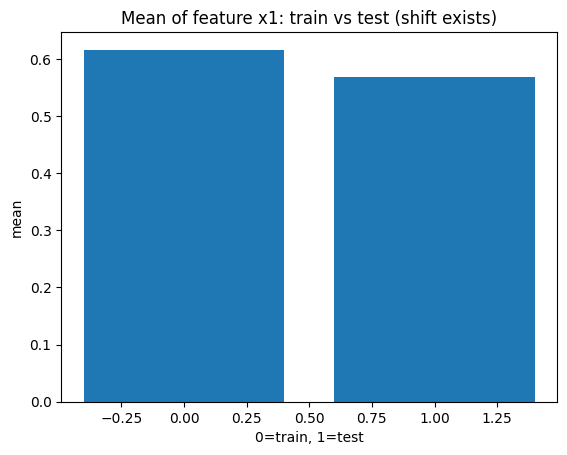

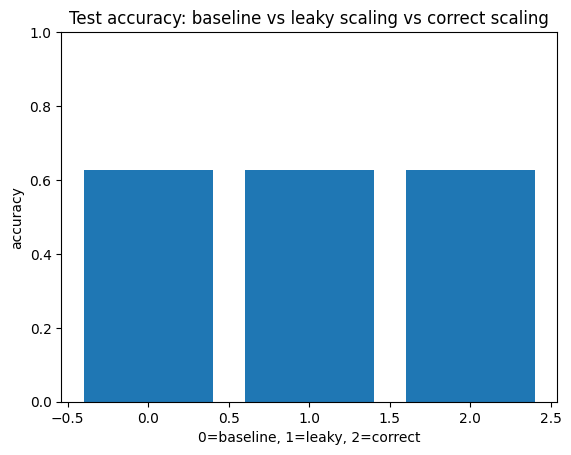

In [2]:
# 1) Baseline
W0, b0 = train_logreg(x_tr, y_tr, lr=0.8, steps=800)
acc_tr0 = accuracy_from_logits(x_tr @ W0 + b0, y_tr)
acc_te0 = accuracy_from_logits(x_te @ W0 + b0, y_te)
print('Baseline acc train:', acc_tr0, 'test:', acc_te0)

# 2) Leakage demo A: scaling on all vs train-only
mu_all, sig_all = standardize_fit(np.vstack([x_tr, x_va, x_te]))
x_tr_all = standardize_apply(x_tr, mu_all, sig_all)
x_te_all = standardize_apply(x_te, mu_all, sig_all)
W_all, b_all = train_logreg(x_tr_all, y_tr, lr=0.8, steps=800)
acc_te_leaky_scaler = accuracy_from_logits(x_te_all @ W_all + b_all, y_te)

mu_tr, sig_tr = standardize_fit(x_tr)
x_tr_ok = standardize_apply(x_tr, mu_tr, sig_tr)
x_te_ok = standardize_apply(x_te, mu_tr, sig_tr)
W_ok, b_ok = train_logreg(x_tr_ok, y_tr, lr=0.8, steps=800)
acc_te_correct_scaler = accuracy_from_logits(x_te_ok @ W_ok + b_ok, y_te)

print('Test acc with LEAKY scaler (fit on all):', acc_te_leaky_scaler)
print('Test acc with correct scaler (fit on train):', acc_te_correct_scaler)

# Plot 1: show how means differ between train and test (shift)
plt.figure()
means = np.vstack([x_tr.mean(axis=0), x_te.mean(axis=0)])
plt.bar([0,1], means[:,0])
plt.title('Mean of feature x1: train vs test (shift exists)')
plt.xlabel('0=train, 1=test')
plt.ylabel('mean')
plt.show()

# Plot 2: compare accuracies
plt.figure()
plt.bar([0,1,2], [acc_te0, acc_te_leaky_scaler, acc_te_correct_scaler])
plt.title('Test accuracy: baseline vs leaky scaling vs correct scaling')
plt.xlabel('0=baseline, 1=leaky, 2=correct')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.show()

Test accuracy with target leakage feature: 1.0


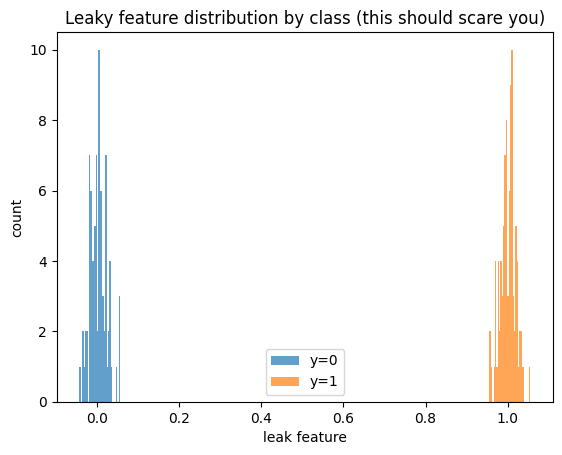

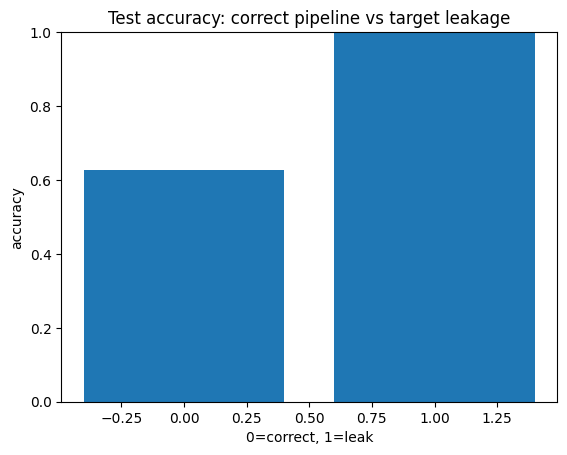

In [3]:
# 3) Leakage demo B: target leakage feature
# Create a feature that is strongly correlated with y (this is equivalent to a bug in feature engineering).
leak = y + 0.02*rng.normal(size=y.shape)
x_leak = np.hstack([x, leak])
xL_tr, yL_tr, xL_va, yL_va, xL_te, yL_te = split_three(x_leak, y, ratios=(0.6,0.2,0.2), rng=rng)

W_leak, b_leak = train_logreg(xL_tr, yL_tr, lr=0.8, steps=500)
acc_te_leak = accuracy_from_logits(xL_te @ W_leak + b_leak, yL_te)
print('Test accuracy with target leakage feature:', acc_te_leak)

# Plot 1: compare distributions of leak feature by class
plt.figure()
plt.hist(xL_te[yL_te[:,0]==0, 2], bins=30, alpha=0.7, label='y=0')
plt.hist(xL_te[yL_te[:,0]==1, 2], bins=30, alpha=0.7, label='y=1')
plt.title('Leaky feature distribution by class (this should scare you)')
plt.xlabel('leak feature')
plt.ylabel('count')
plt.legend()
plt.show()

# Plot 2: accuracy comparison
plt.figure()
plt.bar([0,1], [acc_te_correct_scaler, acc_te_leak])
plt.title('Test accuracy: correct pipeline vs target leakage')
plt.xlabel('0=correct, 1=leak')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.show()

k-fold accuracies: [0.68666667 0.65333333 0.70666667 0.62       0.73333333 0.66      ]
mean +/- std: 0.6766666666666666 0.037068505150249495


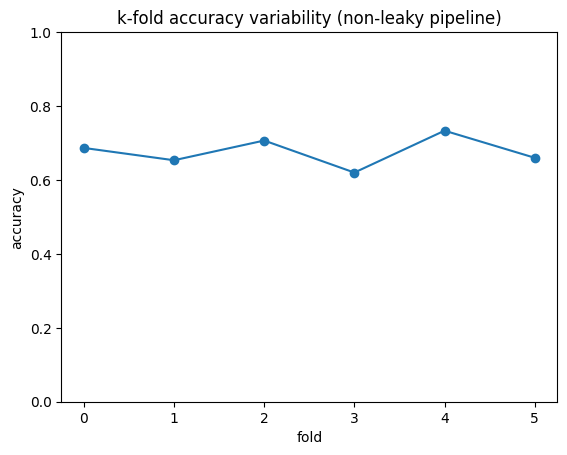

In [4]:
# 4) Manual k-fold (on the non-leaky, correct-scaler setup)
def kfold_indices(N, k, rng):
    idx = rng.permutation(N)
    folds = np.array_split(idx, k)
    return folds

def kfold_eval(x, y, k=5):
    folds = kfold_indices(x.shape[0], k, rng)
    accs = []
    for i in range(k):
        va_idx = folds[i]
        tr_idx = np.hstack([folds[j] for j in range(k) if j != i])
        x_tr, y_tr = x[tr_idx], y[tr_idx]
        x_va, y_va = x[va_idx], y[va_idx]
        # fit scaler on train only
        mu, sig = standardize_fit(x_tr)
        x_tr_s = standardize_apply(x_tr, mu, sig)
        x_va_s = standardize_apply(x_va, mu, sig)
        W, b = train_logreg(x_tr_s, y_tr, lr=0.8, steps=600)
        acc = accuracy_from_logits(x_va_s @ W + b, y_va)
        accs.append(acc)
    return np.array(accs)

accs = kfold_eval(x, y, k=6)
print('k-fold accuracies:', accs)
print('mean +/- std:', accs.mean(), accs.std())

plt.figure()
plt.plot(accs, marker='o')
plt.title('k-fold accuracy variability (non-leaky pipeline)')
plt.xlabel('fold')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.show()

## Reflection questions
1. Why is fitting preprocessing on all data considered leakage?
2. In production, what does “target leakage” look like in real pipelines?
3. Why do we keep test data untouched until the end?
4. What does k-fold add compared to a single split?
5. If your validation metric is excellent but production fails, what should you check first?

## Optional extensions
1. Implement stratified splits (maintain class balance) manually.
2. Create time-ordered data and demonstrate why random splits can leak future information.
3. Compare k-fold results for different k (3, 5, 10).

## Summary
- Train/val/test separation is non-negotiable.
- Leakage can silently inflate metrics.
- Fit preprocessing on train only.
- Target leakage is a pipeline bug, not model skill.
- k-fold helps estimate variability when data is limited.